# Introduction
* "Deep dream" is an image-filtering technique which consists of taking an image classification model, and running gradient ascent over an input image to try to maximize the activations of specific layers (and sometimes, specific units in specific layers) for this input. It produces hallucination-like visuals.

* It was first introduced by Alexander Mordvintsev from Google in July 2015.

# Process:

* Load the original image.
* Define a number of processing scales ("octaves"), from smallest to largest.
* Resize the original image to the smallest scale.
* For every scale, starting with the smallest (i.e. current one): - Run gradient ascent - Upscale image to the next scale - Reinject the detail that was lost at upscaling time
* Stop when we are back to the original size. To obtain the detail lost during upscaling, we simply take the original image, shrink it down, upscale it, and compare the result to the (resized) original image.

In [52]:
!  wget https://static.independent.co.uk/s3fs-public/thumbnails/image/2016/03/10/18/mona-lisa.jpg

--2025-04-05 15:00:43--  https://static.independent.co.uk/s3fs-public/thumbnails/image/2016/03/10/18/mona-lisa.jpg
Resolving static.independent.co.uk (static.independent.co.uk)... 151.101.1.91, 151.101.129.91, 151.101.193.91, ...
Connecting to static.independent.co.uk (static.independent.co.uk)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19762 (19K) [image/jpeg]
Saving to: ‘mona-lisa.jpg.4’

mona-lisa.jpg.4     100%[===================>]  19.30K  --.-KB/s    in 0.001s  

2025-04-05 15:00:43 (27.5 MB/s) - ‘mona-lisa.jpg.4’ saved [19762/19762]



In [53]:
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import tensorflow as tf
import keras
from keras.applications import ResNet50

# Setup

In [54]:
base_image_path="/kaggle/working/mona-lisa.jpg"
result_prefix="monalisa_dream"

In [55]:
# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    "conv2_block2_out": 0.5,  # Low weight for early layer (less semantic)
    "conv4_block1_out": 1.0,  # Moderate weight for mid-layer
    "conv5_block1_out": 2.0,  # High weight for deep layer (semantic)
    "conv4_block6_out": 1.5   # Mid-to-late layer, moderate weight
}

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 30  # Number of ascent steps per scale
max_loss = 15.0

# This is our base image:

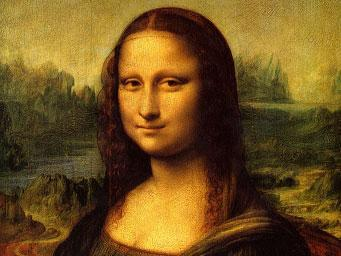

In [56]:
display(Image(base_image_path))

# Let's set up some image preprocessing/deprocessing utilities:

In [57]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
  
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Compute the Deep Dream loss
#### First, build a feature extraction model to retrieve the activations of our target layers given an input image.

In [58]:
model = ResNet50(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]])

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [59]:
for layer in model.layers:
    print(layer.name)


input_layer_5
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


# The actual loss computation is very simple:

In [60]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

# Set up the gradient ascent loop for one octave

In [61]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

# Run the training loop, iterating over different octaves

In [62]:
from tqdm import tqdm

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy

for i, shape in enumerate(tqdm(successive_shapes, desc="Processing Octaves")):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img(result_prefix + ".png", deprocess_image(img.numpy()))


Processing Octaves:   0%|          | 0/3 [00:00<?, ?it/s]

Processing octave 0 with shape (130, 173)
... Loss value at step 0: 2.69
... Loss value at step 1: 2.72
... Loss value at step 2: 2.75
... Loss value at step 3: 2.79
... Loss value at step 4: 2.82
... Loss value at step 5: 2.86
... Loss value at step 6: 2.90
... Loss value at step 7: 2.93
... Loss value at step 8: 2.97
... Loss value at step 9: 3.00
... Loss value at step 10: 3.03
... Loss value at step 11: 3.06
... Loss value at step 12: 3.09
... Loss value at step 13: 3.12
... Loss value at step 14: 3.15


Processing Octaves:  33%|███▎      | 1/3 [00:03<00:06,  3.14s/it]

... Loss value at step 15: 3.19
... Loss value at step 16: 3.22
... Loss value at step 17: 3.25
... Loss value at step 18: 3.28
... Loss value at step 19: 3.31
... Loss value at step 20: 3.34
... Loss value at step 21: 3.37
... Loss value at step 22: 3.40
... Loss value at step 23: 3.43
... Loss value at step 24: 3.46
... Loss value at step 25: 3.48
... Loss value at step 26: 3.51
... Loss value at step 27: 3.54
... Loss value at step 28: 3.56
... Loss value at step 29: 3.59
Processing octave 1 with shape (182, 243)
... Loss value at step 0: 3.46
... Loss value at step 1: 3.53
... Loss value at step 2: 3.59
... Loss value at step 3: 3.65
... Loss value at step 4: 3.70
... Loss value at step 5: 3.76
... Loss value at step 6: 3.81
... Loss value at step 7: 3.86
... Loss value at step 8: 3.91
... Loss value at step 9: 3.96
... Loss value at step 10: 4.01
... Loss value at step 11: 4.06
... Loss value at step 12: 4.11
... Loss value at step 13: 4.16
... Loss value at step 14: 4.20
... Loss

Processing Octaves:  67%|██████▋   | 2/3 [00:06<00:03,  3.06s/it]

... Loss value at step 16: 4.30
... Loss value at step 17: 4.34
... Loss value at step 18: 4.39
... Loss value at step 19: 4.43
... Loss value at step 20: 4.47
... Loss value at step 21: 4.51
... Loss value at step 22: 4.56
... Loss value at step 23: 4.60
... Loss value at step 24: 4.64
... Loss value at step 25: 4.68
... Loss value at step 26: 4.73
... Loss value at step 27: 4.77
... Loss value at step 28: 4.81
... Loss value at step 29: 4.85
Processing octave 2 with shape (256, 341)
... Loss value at step 0: 4.17
... Loss value at step 1: 4.26
... Loss value at step 2: 4.35
... Loss value at step 3: 4.43
... Loss value at step 4: 4.52
... Loss value at step 5: 4.60
... Loss value at step 6: 4.69
... Loss value at step 7: 4.77
... Loss value at step 8: 4.85
... Loss value at step 9: 4.92
... Loss value at step 10: 5.00
... Loss value at step 11: 5.07
... Loss value at step 12: 5.15
... Loss value at step 13: 5.22
... Loss value at step 14: 5.29
... Loss value at step 15: 5.37
... Loss

Processing Octaves: 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]

... Loss value at step 25: 6.05
... Loss value at step 26: 6.11
... Loss value at step 27: 6.18
... Loss value at step 28: 6.24
... Loss value at step 29: 6.30


# Display the result.

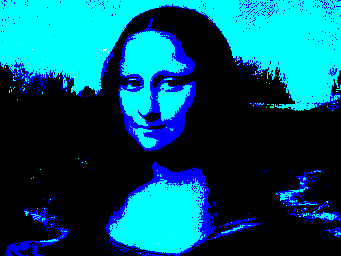

In [63]:
display(Image(result_prefix + ".png"))